[Reference](https://towardsdatascience.com/multi-class-text-classification-with-sklearn-and-nltk-in-python-a-software-engineering-use-case-779d4a28ba5)

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
!pwd
os.chdir('gdrive/My Drive/Colab Notebooks')
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Colab Notebooks


In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
%matplotlib inline
try:
    conn = sqlite3.connect("training_V2.db")
except Error as e:
    print(e)
#reading the data from the table that contains the labels 
df = pd.read_sql_query('SELECT * FROM filtered', conn)
df.drop(['id'], 1, inplace=True)
df.head()

,text,class
0,MAHOUT-1045: committing patch with changes to ...,5
1,Add notes for coptic bug fix and scalar perfor...,5
2,cloudStack 3.0 new UI - NaaS - fix a bug that ...,1
3,"add logic to handle all 2xx response code, bug...",1
4,Fixed adding route for additional public nic o...,1


Labels:
- 1 represents commit messages for bug fixing.
- 2 represents commits that belong to no category.
- 3 represents commit messages for design improvement.
- 4 represents commit messages for adding new features.
- 5 represents commit messages for improving non-functional requirements.

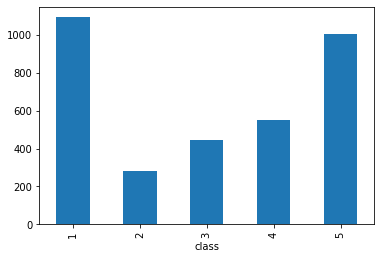

In [3]:
df.groupby('class').text.count().plot.bar(ylim=0)
plt.show()

# Text Preprocessing

In [6]:
stemmer = PorterStemmer()
import nltk
nltk.download('stopwords')
words = stopwords.words("english")
df['cleaned'] = df['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
df.head()

,text,class,cleaned
0,MAHOUT-1045: committing patch with changes to ...,5,mahout commit patch chang unit test cdbw numbe...
1,Add notes for coptic bug fix and scalar perfor...,5,add note coptic bug fix scalar perform improv
2,cloudStack 3.0 new UI - NaaS - fix a bug that ...,1,cloudstack new ui naa fix bug dedic paramet di...
3,"add logic to handle all 2xx response code, bug...",1,add logic handl xx respons code bug fix string...
4,Fixed adding route for additional public nic o...,1,fix ad rout addit public nic fail


In [8]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(df['cleaned']).toarray()
final_features.shape

(3377, 2389)

In [10]:
final_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

![WorkFlow](https://miro.medium.com/max/1400/1*6ku25gAB-_SLtxVNyBkl9w.jpeg)

In [11]:
#first we split our dataset into testing and training set:
# this block is to split the dataset into training and testing set 
X = df['cleaned']
Y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
# instead of doing these steps one at a time, we can use a pipeline to complete them all at once
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', RandomForestClassifier())])
# fitting our model and save it in a pickle for later use
model = pipeline.fit(X_train, y_train)
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(model, f)
ytest = np.array(y_test)
# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

              precision    recall  f1-score   support

           1       0.98      1.00      0.99       288
           2       1.00      0.93      0.96        71
           3       0.99      1.00      1.00       108
           4       0.99      0.99      0.99       138
           5       1.00      1.00      1.00       240

    accuracy                           0.99       845
   macro avg       0.99      0.98      0.99       845
weighted avg       0.99      0.99      0.99       845

[[288   0   0   0   0]
 [  4  66   0   1   0]
 [  0   0 108   0   0]
 [  1   0   0 137   0]
 [  0   0   1   0 239]]
